In [7]:
import shutil
import os
root_name = "./log2-[Y=XM+C]-grid"
logs_dir = os.listdir(root_name)
for logs_name in logs_dir:
    log_files = os.listdir("%s/%s" % (root_name, logs_name))
    print(logs_name, log_files[-1])
    

order[001]-iter[ 10]-epoch[200]-lambda1[0.200]-lambda2[0.001]-rho[0.001] iter[010, 200]-pnsr[19.266, 19.292]-ssim[0.000]-mse[1.21246E+05]-loss[4.68552E+01].png
order[002]-iter[ 10]-epoch[200]-lambda1[0.200]-lambda2[0.010]-rho[0.001] iter[010, 200]-pnsr[17.131, 17.134]-ssim[0.000]-mse[1.98252E+05]-loss[7.05238E+01].png
order[003]-iter[ 10]-epoch[200]-lambda1[0.200]-lambda2[0.100]-rho[0.001] iter[010, 200]-pnsr[16.697, 16.698]-ssim[0.000]-mse[2.19097E+05]-loss[3.69134E+02].png
order[004]-iter[ 10]-epoch[200]-lambda1[0.200]-lambda2[1.000]-rho[0.001] iter[010, 200]-pnsr[17.005, 17.007]-ssim[0.000]-mse[2.04083E+05]-loss[2.85902E+04].png
order[005]-iter[ 10]-epoch[200]-lambda1[2.000]-lambda2[0.001]-rho[0.010] iter[010, 200]-pnsr[32.533, 34.224]-ssim[0.000]-mse[5.71434E+03]-loss[2.45862E+02].png
order[006]-iter[ 10]-epoch[200]-lambda1[2.000]-lambda2[0.010]-rho[0.010] iter[010, 200]-pnsr[33.961, 35.394]-ssim[0.000]-mse[4.11314E+03]-loss[2.71266E+02].png
order[007]-iter[ 10]-epoch[200]-lambda1[

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

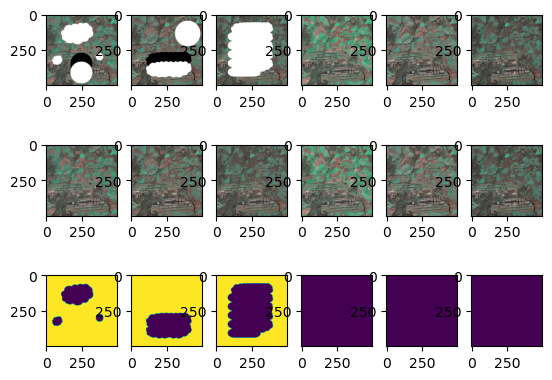

In [13]:
from __future__ import print_function

import os
import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import torch
import torch.optim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from architecture import MST

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
# dtype = torch.cuda.DoubleTensor
# dtype = torch.double
device = torch.device('cuda')
torch.cuda.manual_seed(seed=666)


########################################### 辅助函数 ###########################################
def thres_21(L, tau, M, N, B):
    S = torch.sqrt(torch.sum(torch.mul(L, L), 2))
    S[S == 0] = 1
    T = 1 - tau / S
    T[T < 0] = 0
    R = T.reshape(M, N, 1).repeat((1, 1, B))
    res = torch.mul(R, L)
    return res


################################ 读取数据 ################################
YY= mat73.loadmat("./Data/T31UDQ/T31UDQ_20m_raw1.mat")['T31UDQ_20m_raw1'] 
YY = np.double(YY)
YY = YY/YY.max()

Mask2_500 = mat73.loadmat("./Data/Mask2_500.mat")['Mask2_500']
Mask_Out_500 = mat73.loadmat("./Data/Mask_Out_500.mat")["Mask_Out_500"]
Mask_Shd = mat73.loadmat("./Data/Mask_Shd.mat")["Mask_Shd"]
Mask_shad = mat73.loadmat("./Data/Mask_shad.mat")["Mask_shad"]
Mask = np.copy(Mask2_500)
Mask[ Mask != 0 ] = 1
# Test1_Clean是干净图像，取的是4，2，0三个时相
Test1_Clean = np.copy(YY[:, :, :, [4, 2, 0]])

# 生成云图YY，含有6个时相
Clean = YY[:, :, :, [4, 2, 0, 5, 3, 1]]
YY = np.multiply((1 - Mask), (YY[:, :, :, [4, 2, 0, 5, 3, 1]])) + Mask
YY = np.multiply((1 - Mask_Out_500),  YY) + Mask_Out_500
YY = np.multiply(YY, (1 - Mask_Shd) ) - Mask_Shd
YY = np.multiply(YY, (1 - Mask_shad) ) - Mask_shad
Noisy = np.copy(YY)
Cloud = np.copy(Mask)
Mask = 1 - Cloud
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.imshow(Noisy[:, :, [4, 2, 1], i]*5)

    plt.subplot(3, 6, i+7)
    plt.imshow(Clean[:, :, [4, 2, 1], i]*5)

    plt.subplot(3, 6, i+13)
    plt.imshow(Mask[:, :, 0, i]*5)

plt.show()

In [24]:
a = [1, 2, 3]
print("psnr%s" % a)

psnr[1, 2, 3]


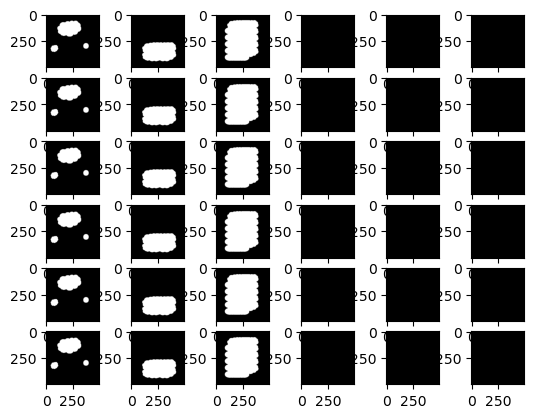

In [20]:
for i in range(6):
    for j in range(6):
        plt.subplot(6, 6, i*6 + j+1)
        plt.imshow(Cloud[:, :, i, j]*5, cmap='gray')

plt.show()

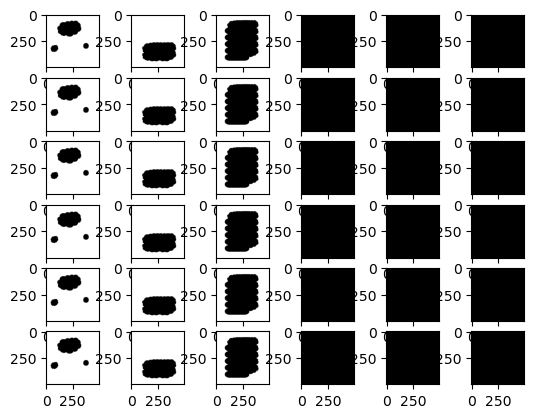

In [19]:
Mask = 1 - Cloud
for i in range(6):
    for j in range(6):
        plt.subplot(6, 6, i*6 + j+1)
        plt.imshow(Mask[:, :, i, j]*5, cmap='gray')

plt.show()

In [21]:
res = Mask[:, :, :, 3:] == 1
res.all()

True

In [ ]:
from skimage.measure import compare_ssim, compare_psnr, compare_mse
import cv2

img1 = cv2.imread(r'C:\Users\Wxr\Desktop\WATERLOO\train_low_high\29.jpg')
img2 = cv2.imread(r'C:\Users\Wxr\Desktop\WATERLOO\train_normal\29.jpg')

psnr = compare_psnr(img1, img2)
ssim = compare_ssim(img1, img2, multichannel=True)  # 对于多通道图像(RGB、HSV等)关键词multichannel要设置为True
mse = compare_mse(img1, img2)

print('PSNR：{}，SSIM：{}，MSE：{}'.format(psnr, ssim, mse))


In [1]:
from __future__ import print_function

import os
import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import torch
import torch.optim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from architecture import MST

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
# dtype = torch.cuda.DoubleTensor
# dtype = torch.double
device = torch.device('cuda')
torch.cuda.manual_seed(seed=666)


########################################### 辅助函数 ###########################################
def thres_21(L, tau, M, N, B):
    S = torch.sqrt(torch.sum(torch.mul(L, L), 2))
    S[S == 0] = 1
    T = 1 - tau / S
    T[T < 0] = 0
    R = T.reshape(M, N, 1).repeat((1, 1, B))
    res = torch.mul(R, L)
    return res


################################ 读取数据 ################################
YY= mat73.loadmat("./Data/T31UDQ/T31UDQ_20m_raw1.mat")['T31UDQ_20m_raw1']

compare_ssim(YY[:, :, 0, 0], YY[:, :, 0, 1])

0.9951254132260957